# Text to SQL Generation for BigQuery using Vertex AI PALM API

One of LLM capability to improve developer productivity is generating SQL query based on natual language prompting. This feature enabale various use case in analyzing data from data warehouse in BigQuery. Some of possible use case are:
- Data analyst chatbot. Enable QnA directly between end user with their business data via natural language.
- Dashboard generator automation. An automatic dashboard that able to create insights from data in data warehouse.
- Data analyst asistant. An assistant to data analyst and BI developer in creating, validating, and analyzing SQL query.



In this tutorial, we will waltkthrough various prompting techniques for LLM to generate SQL statement for Google BigQuery. We will be using text-bison@001 model from Vertex AI PALM API.


# Install Vertex AI SDK and Other Packages
We will be using Vertex AI SDK and some Python packages such as Pandas and Plotly.

In [40]:
!pip install google-cloud-aiplatform pandas google-api-python-client langchain

We will be using [Python Client fo BigQuery](https://cloud.google.com/python/docs/reference/bigquery/latest) to connect directly to BigQuery's dataset and table.  

In [3]:
# import required packages
import vertexai
import pandas as pd
from vertexai.language_models import TextGenerationModel
from google.cloud import aiplatform
from google.cloud import bigquery
import os

from IPython.display import Markdown as md


## Specify project detail and location

In [4]:
#change projectid as required

project_id = "myprojectid"  # @param {type:"string"}
location = "us-central1"  # @param {type:"string"}
dataset_id = 'rabbitconsulting' # @param {type:"string"}


In [5]:
# authenticate to google cloud account

# use the following auth method ONLY if you use google colab

#from google.colab import auth as google_auth
#google_auth.authenticate_user()

## Initiate Vertex AI LLM and BigQuery client

In [6]:
vertexai.init(project=project_id, location=location)
generation_model = TextGenerationModel.from_pretrained(model_name="text-bison@001")

bq_client = bigquery.Client(project=project_id, location=location)

# Load Sample Dataset to BigQuery

In [ ]:
#create bigquery dataset

#define fullt qualified dataset name: "projectid.datasetid"
dataset_id = "{}.{}".format(project_id, dataset_id)

#create BigQuery dataset
dataset = bq_client.create_dataset(dataset_id, timeout=30)
print("Created dataset {}.{}".format(bq_client.project, dataset.dataset_id))

In [9]:
#get csv file from repository

customerfile= 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit_customer_dummy.csv'
ordertransactionfile = 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit-customer-transaction.csv'
surveyfile = 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit-satisfactionsurvey.csv'

In [10]:
#create function to import csv to BigQuery
def import_csv_to_bq (filepath, table_id):

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True,
          write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE )

  df = pd.read_csv(filepath, delimiter=',', )
  load_job = bq_client.load_table_from_dataframe(dataframe=df,
                                          destination=table_id,
                                            job_config=job_config)  # Make an API request.


  load_job.result()  # Waits for the job to complete.

  table = bq_client.get_table(table_id)  # Make an API request.
  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
)

In [14]:
#import customer csv
tablename = 'customerdata'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(customerfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

myprojectid.rabbitconsulting.customerdata
Loaded 58 rows and 7 columns to myprojectid.rabbitconsulting.customerdata


,custid,custname,dateofbirth,city_address,nationality,memberstatus,education
0,31,Mickey Mouse,1950-01-01,Jakarta,Indonesia,YES,Bachelor
1,8,Iron Man,1960-03-03,Pontianak,Indonesia,NO,Doctorate
2,20,Beast,1960-03-03,Jambi,Indonesia,NO,Doctorate
3,38,Dale,1960-03-03,Pontianak,Indonesia,NO,Doctorate
4,50,Max Goof,1960-03-03,Jambi,Indonesia,NO,Doctorate


In [15]:
#import order transaction to BigQuery
tablename = 'ordertransaction'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(ordertransactionfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

myprojectid.rabbitconsulting.ordertransaction
Loaded 279 rows and 7 columns to myprojectid.rabbitconsulting.ordertransaction


,transactionid,custid,transactsitelocation,transactiondate,servicecategory,transactionamount,servingconsultant
0,TX3008,27,Surabaya,2022-01-08,Eye Care,800000,Ema
1,TX3028,33,Bandung,2022-01-28,Eye Care,800000,Ema
2,TX3040,21,Bandung,2022-02-10,Covid Test,2900000,Ema
3,TX1004,12,Bandung,2023-03-11,Consultation,500000,Ema
4,TX1024,12,Bandung,2023-03-31,Consultation,500000,Ema


In [16]:
#import survey data to BigQuery
tablename = 'satisfactionsurvey'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(surveyfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

myprojectid.rabbitconsulting.satisfactionsurvey
Loaded 279 rows and 2 columns to myprojectid.rabbitconsulting.satisfactionsurvey


,transactionid,surveyscore
0,TX3070,61
1,TX3091,61
2,TX3093,61
3,TX5147,61
4,TX3027,62


# Create Prompt for Text to SQL

In [17]:
#create text string for prompt input to the model
#define prompt engineering to generate SQL query

#important: change myprojectid to your projectname

#always limit query result to 50 rows as default row number, to save query cost
def custom_prompt(question, top_k=50):
    # question: user question
    # top_k: limit number of rows returned - default is 50

    prompt = """
    You are a GoogleSQL expert. This is a task converting text into GoogleSQL statement.
    Use the following information to create a syntactically correct BigQuery query

    Table information:
    Table \"myprojectid.rabbitconsulting.customerdata\" contains customer detail information
    Table \"myprojectid.rabbitconsulting.ordertransaction\" contains detail transaction for each customer
    Table \"myprojectid.rabbitconsulting.satisfactionsurvey\" contains score for satisfaction survey of each transaction

    Table and columns as follows:
    Table \"myprojectid.rabbitconsulting.customerdata\"
    Columns: custid (primary key), custname, dateofbirth, city_address, nationality, memberstatus, education

    Table \"myprojectid.rabbitconsulting.ordertransaction\"
    Columns: transactionid (primary key), custid (foreign key), transactsitelocation, transactiondate, servicecategory, transactionamount, servingconsultant

    Table \"myprojectid.rabbitconsulting.satisfactionsurvey\"
    Columns: transactionid (foreign key), surveyscore


    The join between tables:
    one to many join: myprojectid.rabbitconsulting.customerdata.custid = myprojectid.rabbitconsulting.ordertransaction.custid
    one to many join: myprojectid.rabbitconsulting.ordertransaction.transactionid = myprojectid.rabbitconsulting.satisfactionsurvey.transactionid

    Only use fields from each respecting table. Never use column that does not exists in the table.
    Wrap each column name in backticks (`) to denote them as delimited identifiers.

    Examples:
    question: show average sales for each city when transaction happened in Jan-march 2023
    answer: SELECT `city_address`, AVG(`transactionamount`) AS average_sales FROM myprojectid.rabbitconsulting.`ordertransaction` AS o JOIN myprojectid.rabbitconsulting.`customerdata` AS c ON c.`custid` = o.`custid` WHERE `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' GROUP BY `city_address`

    question: show average satisfaction score for each consultant
    answer: SELECT `servingconsultant`, AVG(`surveyscore`) AS average_satisfaction_score FROM myprojectid.rabbitconsulting.`ordertransaction` AS o JOIN myprojectid.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` GROUP BY `servingconsultant`

    question: show total sales, transaction frequency, and average score for each city
    answer: SELECT `city_address`, SUM(`transactionamount`) AS total_sales, COUNT(o.`transactionid`) AS transaction_frequency, AVG(`surveyscore`) AS average_score FROM myprojectid.rabbitconsulting.`customerdata` AS c JOIN myprojectid.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN myprojectid.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` GROUP BY `city_address`

    Always limit query using at most """ + str(top_k) + """ results using LIMIT clause.
    If you cannot find the information or not sure, response "I do not have enough data"
    If the answer require DML or DDL statement, reject and response "Command not allowed"
    If the answer require query to INFORMATION_SCHEMA, reject and response "Command not allowed"
    Never make up the answer.

    Let's think step by step

    Create SQL statement from the following question
    question: """ + question

    return prompt

In [18]:
#test prompt text template
myquestion = "show total sales for each city"
custom_prompt(myquestion)

'\n    You are a GoogleSQL expert. This is a task converting text into GoogleSQL statement.\n    Use the following information to create a syntactically correct BigQuery query\n\n    Table information:\n    Table "myprojectid.rabbitconsulting.customerdata" contains customer detail information\n    Table "myprojectid.rabbitconsulting.ordertransaction" contains detail transaction for each customer\n    Table "myprojectid.rabbitconsulting.satisfactionsurvey" contains score for satisfaction survey of each transaction\n\n    Table and columns as follows:\n    Table "myprojectid.rabbitconsulting.customerdata"\n    Columns: custid (primary key), custname, dateofbirth, city_address, nationality, memberstatus, education\n\n    Table "myprojectid.rabbitconsulting.ordertransaction"\n    Columns: transactionid (primary key), custid (foreign key), transactsitelocation, transactiondate, servicecategory, transactionamount, servingconsultant\n\n    Table "myprojectid.rabbitconsulting.satisfactionsurve

In [19]:
#using palm api from scratch to generate sql query

#define function to call PALM LLM model
def create_query(question, top_k=50):

    #generate custom prompt
    q = custom_prompt(question, top_k)

    generated_query = generation_model.predict(
        prompt=q,
        max_output_tokens=1024,
        temperature=0.0
        ).text

    return generated_query

In [20]:
#test to generate SQL query #1
create_query("show average sales, order frequency, and average score for each city when order period is between Jan - march 2023, then order by highest sales")

"SELECT `city_address`, SUM(`transactionamount`) AS total_sales, COUNT(o.`transactionid`) AS transaction_frequency, AVG(`surveyscore`) AS average_score FROM myprojectid.rabbitconsulting.`customerdata` AS c JOIN myprojectid.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN myprojectid.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` WHERE `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' GROUP BY `city_address` ORDER BY total_sales DESC LIMIT 50"

In [21]:
#test to generate SQL query #3
create_query("tampilkan 10 order dari jakarta and surabaya dalam periode Jan - March 2023")

"SELECT * FROM myprojectid.rabbitconsulting.`ordertransaction` AS o JOIN myprojectid.rabbitconsulting.`customerdata` AS c ON c.`custid` = o.`custid` WHERE `city_address` IN ('Jakarta', 'Surabaya') AND `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' LIMIT 10"

In [22]:
#test to generate SQL query #4
#this query is prohibited!
create_query("SELECT * FROM myprojectid.rabbitconsulting.INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'customerdata'")

'Command not allowed'

#Execute Generated SQL to BigQuery

## Create Function to Retrieve BQ Data

In [23]:
#create function to execute generated query to BQ

def bq_qa_llm(userquery, top_k=50):

    query_job = bq_client.query(
                                create_query(userquery, top_k))

    rows = query_job.result()
    return rows.to_dataframe()


In [24]:
#test to generate SQL query & execute to BQ #1
#limit to 10 rows
bq_qa_llm("show average sales, order frequency, and average score for each city when order period is between Jan - march 2023, then order by highest sales", 10)

,city_address,total_sales,transaction_frequency,average_score
0,Manado,9000000,3,88.000000
1,Makassar,8500000,4,79.250000
2,Pontianak,7000000,4,72.000000
3,Bandar Lampung,6500000,3,79.666667
4,Ambon,6500000,4,79.500000
5,Kupang,6200000,3,70.000000
6,Banjarmasin,5500000,4,73.250000
7,Pekanbaru,5500000,3,77.000000
8,Palembang,5500000,4,81.000000
9,Jambi,4000000,3,78.333333


In [27]:
bq_qa_llm("Tampilkan top 3 Layanan yang penjualannya paling bagus ")

,servicecategory,total_sales
0,Covid Test,159300000
1,Skin Care,109000000
2,General Checkup,105200000


In [28]:
bq_qa_llm("tampilkan total penjualan, frekuensi order, dan rata rata skor survey for untuk tiap konsultan. urutkan dari penjualan tertinggi")

,servingconsultant,total_sales,transaction_frequency,average_score
0,Ahmad,134900000,71,80.549296
1,Ema,120700000,69,82.159420
2,Boby,118200000,65,72.815385
3,Rany,114500000,65,76.430769


## Explaining SQL Query in Human Language

In [29]:
#using palm api to explain the logic of sql query
def create_explanation(question, sql_answer):

    explain_prompt="""
            You are an expert data analyst working with python, SQL, and pandas.
            For the SQL query you have just created, explain why you have that ouput and how does it answer the question.

            the original question is: """ + question + """
            your answer in SQL is: """ + sql_answer + """

            Explain how you came up with SQL code for non-technical people without mentioning technical details or mentioning the libraries used?
            Always explain in Bahasa Indonesia

            Explain your response using the following structure:

            Objective: explain the objective by rephrase the original question \n
            Explanation: write your explanation for non technical people. please be concise and simple.
            """

    explanation = generation_model.predict(
        prompt=explain_prompt,
        max_output_tokens=1024,
        temperature=0.1,
        top_k=40,
        top_p=0.8
        ).text

    return explanation

In [30]:
#explain generated SQL Query for non technical person
original_question = "show total orders amount and frequency from jakarta and surabaya in the period Jan - Jun 2023"
sqlanswer = create_query(original_question)
display(md(sqlanswer))

#generate and display explanation
explain_sql = create_explanation(original_question, sqlanswer)
display(md(explain_sql))

SELECT `city_address`, SUM(`transactionamount`) AS total_orders_amount, COUNT(o.`transactionid`) AS transaction_frequency FROM myprojectid.rabbitconsulting.`customerdata` AS c JOIN myprojectid.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN myprojectid.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` WHERE `city_address` IN ('Jakarta', 'Surabaya') AND `transactiondate` BETWEEN '2023-01-01' AND '2023-06-30' GROUP BY `city_address` LIMIT 50

**Objective:**

            Menampilkan jumlah total transaksi dan frekuensi transaksi dari Jakarta dan Surabaya pada periode Januari - Juni 2023.

            **Explanation:**

            Untuk menjawab pertanyaan tersebut, saya menggunakan perintah SELECT untuk memilih kolom `city_address`, `total_orders_amount`, dan `transaction_frequency`. Kolom `city_address` digunakan untuk memilih data transaksi dari Jakarta dan Surabaya. Kolom `total_orders_amount` digunakan untuk menghitung jumlah total transaksi. Kolom `transaction_frequency` digunakan untuk menghitung frekuensi transaksi.

            Selanjutnya, saya menggunakan perintah JOIN untuk menggabungkan tiga tabel yaitu `customerdata`, `ordertransaction`, dan `satisfactionsurvey`. Perintah JOIN digunakan untuk menghubungkan data dari tiga tabel tersebut berdasarkan kolom `custid` dan `transactionid`.

            Kemudian, saya menggunakan perintah WHERE untuk memfilter data transaksi yang terjadi pada periode Januari - Juni 2023.

            Terakhir, saya menggunakan perintah GROUP BY untuk mengelompokkan data berdasarkan kolom `city_address`.

            Dengan menggunakan perintah-perintah tersebut, saya berhasil menampilkan jumlah total transaksi dan frekuensi transaksi dari Jakarta dan Surabaya pada periode Januari - Juni 2023.

# Experimenting with Langchain Agent to do Complex QnA

In [41]:
#using langchain dataframe agent to explain and getting insights from dataframe
from langchain.agents.agent_types import AgentType
from langchain.llms import VertexAI
from langchain.agents.agent_toolkits import create_pandas_dataframe_agent

In [42]:
#1. generate sql
#2. execute sql to BQ, then retrieve as pandas dataframe
#3. use create_pandas_dataframe_agent to explain dataframe

#get dataframe
df = bq_qa_llm("show average sales, order frequency, and average score for each city when order period is between Jan - march 2023")

#getting insights from dataframe
agent = create_pandas_dataframe_agent(
    VertexAI(temperature=0, model="text-bison@001"),
    df,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    max_iterations=6
)

agent.run("explain 3 interesting insights from the data")



> Entering new AgentExecutor chain...
 Thought: The average sales in Bandung is the highest, followed by Manado and Kupang.
Action: python_repl_ast
Action Input: df.sort_values('average_sales', ascending=False).head(3)
Observation:    city_address  average_sales  transaction_frequency  average_score
2       Bandung      3000000.0                      1           90.0
4        Manado      3000000.0                      3           88.0
18        Medan      2500000.0                      1           90.0
Thought: The average score in Bandung is the highest, followed by Medan and Jambi.
Action: python_repl_ast
Action Input: df.sort_values('average_score', ascending=False).head(3)
Observation:    city_address  average_sales  transaction_frequency  average_score
18        Medan      2500000.0                      1           90.0
2       Bandung      3000000.0                      1           90.0
8       Mataram      1500000.0                      1           90.0
Thought: The transactio

'1. Bandung has the highest average sales, average score, and the lowest transaction frequency. \n2. Jambi has the second highest average score but the second lowest average sales and transaction frequency. \n3. Manado has the second highest average sales but the average score and transaction frequency are in the middle.'

In [45]:
#create another dataframe and analyze

#get dataframe
df = bq_qa_llm("show order amount, customername, city, and product for period is between Jan - march 2023")

#getting insights from dataframe
agent = create_pandas_dataframe_agent(
    VertexAI(temperature=0.3,
    model_name="text-bison@001"),
    df,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    max_iterations=6
)

agent.run("berikan insights dengan membandingkan order amount customer dari tiap kota")



> Entering new AgentExecutor chain...
Thought: I need to group the data by city and calculate the sum of transaction amount
Action: python_repl_ast
Action Input: df.groupby('city_address').sum()
Observation:                 transactionamount  \
city_address                        
Ambon                     6500000   
Bandar Lampung            6500000   
Bandung                   3000000   
Banjarmasin               5500000   
Denpasar                  1000000   
Jambi                     4000000   
Jayapura                  2000000   
Kupang                    6200000   
Makassar                  8500000   
Manado                    9000000   
Mataram                   1500000   
Medan                     2500000   
Padang                    1500000   
Palembang                 5500000   
Pekanbaru                 5500000   
Pontianak                 7000000   
Semarang                  2500000   
Surabaya                   500000   
Yogyakarta                1000000   

            

'The city with the highest order amount is Makassar, with a total of 8500000. The city with the second highest order amount is Manado, with a total of 9000000. The city with the third highest order amount is Bandar Lampung, with a total of 6500000.'

In [37]:
#pertanyaan lain, dengan menggunakan dataframe yang sama
agent.run("berikan insights penjualan produk paling laku di tiap kota")



> Entering new AgentExecutor chain...
Thought: I need to find the most popular product in each city
Action: python_repl_ast
Action Input: df.groupby('city_address').servicecategory.value_counts()
Observation: city_address    servicecategory
Ambon           Consultation       2
                Covid Test         1
                Skin Care          1
Bandar Lampung  General Checkup    1
                Covid Test         1
                Consultation       1
Bandung         Covid Test         1
Banjarmasin     Eye Care           2
                Covid Test         1
                Consultation       1
Denpasar        Eye Care           1
Jambi           Consultation       2
                General Checkup    1
Jayapura        Eye Care           2
Kupang          General Checkup    2
                Skin Care          1
Makassar        Consultation       2
                Covid Test         1
                Skin Care          1
Manado          Covid Test         3
Mataram         S

'The most popular product in Ambon is Consultation, in Bandar Lampung is General Checkup, in Bandung is Covid Test, in Banjarmasin is Eye Care, in Denpasar is Eye Care, in Jambi is Consultation, in Jayapura is Eye Care, in Kupang is General Checkup, in Makassar is Consultation, in Manado is Covid Test, in Mataram is Skin Care, in Medan is General Checkup, in Padang is Skin Care, in Palembang is Eye Care, in Pekanbaru is General Checkup, in Pontianak is Skin Care, in Semarang is General Checkup, in Surabaya is Consultation,'



> Entering new AgentExecutor chain...
Thought: I need to group the data by service category and calculate the total transaction amount. Then I can plot a bar chart.
Action: python_repl_ast
Action Input: df.groupby('servicecategory').transactionamount.sum().plot.bar()
Observation: Axes(0.125,0.11;0.775x0.77)
Thought:I now know the final answer
Final Answer:

> Finished chain.


''

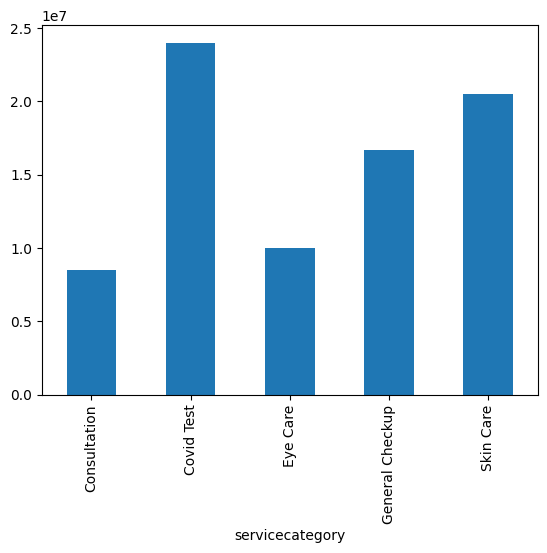

In [39]:
# generate visualization using agent
agent.run("tampilkan total penjualan tiap produk dalam bar chart")

# Further References
- https://medium.com/google-cloud/architectural-patterns-for-text-to-sql-leveraging-llms-for-enhanced-bigquery-interactions-59756a749e15

- https://github.com/GoogleCloudPlatform/genai-for-marketing

- https://github.com/mchoirul/chatmydata

- https://github.com/chatgpt/chart
